In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import zipfile
import os
import csv
import gc
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt


from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression,  LogisticRegressionCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.metrics import roc_auc_score,roc_curve, RocCurveDisplay, auc, make_scorer, ConfusionMatrixDisplay, confusion_matrix, classification_report
import zipfile
from xgboost import XGBClassifier
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import GradientBoostingClassifier,  HistGradientBoostingClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.inspection import permutation_importance

from sklearn.utils import class_weight
from vecstack import stacking, StackingTransformer
import dill

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer

In [ ]:
#Пересоберем тут же датасет, чтобы все было под рукой (см FeatureEngineering.ipynb)
#К базовому набору признаков ДО агрегации добавим: 
#1.  флаг о том, что по продукту не было ни одной просрочки

def count_zero_loans(data):
    zero_loans = ['is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060', 'is_zero_loans6090', 'is_zero_loans90']
    data["no_delays"] =  data.loc[:, zero_loans].eq(1).sum(axis=1).apply(lambda x:1 if x==5 else 0)
    return data

#2. посчитаем количество статусов платежей по продукту за все время 

def count_enc_payments_status(data):
    features_paym = ['enc_paym_0', 'enc_paym_1', 'enc_paym_2', 'enc_paym_3', 'enc_paym_4', 'enc_paym_5', 'enc_paym_6', 'enc_paym_7', 'enc_paym_8', 'enc_paym_9', 'enc_paym_10', 'enc_paym_11', 
            'enc_paym_12', 'enc_paym_13', 'enc_paym_14', 'enc_paym_15', 'enc_paym_16', 'enc_paym_17', 'enc_paym_18', 'enc_paym_19', 'enc_paym_20', 'enc_paym_21', 'enc_paym_22', 
            'enc_paym_23', 'enc_paym_24']
    
    data["enc_paym_value0"] =  data.loc[:, features_paym].eq(0).sum(axis=1)
    data['enc_paym_value1'] =  data.loc[:, features_paym].eq(1).sum(axis=1)
    data['enc_paym_value2'] =  data.loc[:, features_paym].eq(2).sum(axis=1)
    data['enc_paym_value3'] =  df.loc[:, features_paym].eq(3).sum(axis=1)
  
    
    return data

df = pd.read_parquet('/kaggle/input/originaldata/train_data/train_data_0.pq')
cols_to_drop = ['pre_since_opened', 'pre_since_confirmed', 'pre_till_pclose', 'pre_till_fclose', 'pre_loans_total_overdue']
columns_to_ohe = df.columns.tolist()
columns_to_ohe.remove('id')
columns_to_ohe.remove('rn')
columns_to_ohe = list(set(columns_to_ohe) - set(cols_to_drop))

ohe = OneHotEncoder(sparse_output=False)

def payments(data):
    features_paym = ['enc_paym_0', 'enc_paym_1', 'enc_paym_2', 'enc_paym_3', 'enc_paym_4', 'enc_paym_5', 'enc_paym_6', 'enc_paym_7', 'enc_paym_8', 'enc_paym_9', 'enc_paym_10', 'enc_paym_11', 
            'enc_paym_12', 'enc_paym_13', 'enc_paym_14', 'enc_paym_15', 'enc_paym_16', 'enc_paym_17', 'enc_paym_18', 'enc_paym_19', 'enc_paym_20', 'enc_paym_21', 'enc_paym_22', 
            'enc_paym_23', 'enc_paym_24']
    
    data[['enc_paym_11', 'enc_paym_20', 'enc_paym_24' ]] = data[['enc_paym_11', 'enc_paym_20', 'enc_paym_24' ]].replace([1, 2, 3, 4], [0, 1 , 2, 3])
    return data

def ohe_prep(data, cols): 
    
    ohe_ds = ohe.fit_transform(data[cols])
    ohe_features = ohe.get_feature_names_out()
    data = data.join(pd.DataFrame(ohe_ds, columns = ohe_features, index=data.index)).drop(cols, axis=1)
    return data

def aggregate_prep(data):
    columns_to_sum = list(data.columns)
    columns_to_sum.remove('rn')
    columns_to_sum.remove('id')
    aux = {k:'sum' for k in columns_to_sum}
    aux['rn'] = 'max'
    data = data.groupby('id').aggregate(aux)
    data[columns_to_sum]=data[columns_to_sum]
    return data

cols_to_read = df.columns.tolist()
for i in cols_to_drop:
    cols_to_read.remove(i)
    
import os
import pandas as pd
import tqdm



def read_parquet_dataset_from_local(path_to_dataset: str, start_from: int = 0,
                                     num_parts_to_read: int = 2, columns=None, verbose=False) -> pd.DataFrame:
    """
    читает num_parts_to_read партиций, преобразовывает их к pd.DataFrame и возвращает
    :param path_to_dataset: путь до директории с партициями
    :param start_from: номер партиции, с которой нужно начать чтение
    :param num_parts_to_read: количество партиций, которые требуется прочитать
    :param columns: список колонок, которые нужно прочитать из партиции
    :return: pd.DataFrame
    """

    res = []
    dataset_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset)
                              if filename.startswith('train')])
    print(dataset_paths)

    start_from = max(0, start_from)
    chunks = dataset_paths[start_from: start_from + num_parts_to_read]
    if verbose:
        print('Reading chunks:\n')
        for chunk in chunks:
            print(chunk)
    for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):
        print('chunk_path', chunk_path)
        chunk = pd.read_parquet(chunk_path,columns=cols_to_read)
        res.append(chunk)

    return pd.concat(res).reset_index(drop=True)

def prepare_transactions_dataset(path_to_dataset: str, num_parts_to_preprocess_at_once: int = 1, num_parts_total: int=50,
                                 save_to_path=None, verbose: bool=False):
    """
    возвращает готовый pd.DataFrame с признаками, на которых можно учить модель для целевой задачи
    path_to_dataset: str
        путь до датасета с партициями
    num_parts_to_preprocess_at_once: int
        количество партиций, которые будут одновременно держаться и обрабатываться в памяти
    num_parts_total: int
        общее количество партиций, которые нужно обработать
    save_to_path: str
        путь до папки, в которой будет сохранён каждый обработанный блок в .parquet-формате; если None, то не будет сохранён
    verbose: bool
        логирует каждую обрабатываемую часть данных
    """
    preprocessed_frames = []

    for step in tqdm.tqdm_notebook(range(0, num_parts_total, num_parts_to_preprocess_at_once),
                                   desc="Transforming transactions data"):
        transactions_frame = read_parquet_dataset_from_local(path_to_dataset, step, num_parts_to_preprocess_at_once,
                                                             verbose=verbose)

        transactions_frame = payments(transactions_frame) 
        transactions_frame = count_enc_payments_status(transactions_frame) 
        transactiond_frame = count_zero_loans(transactions_frame)
        transactions_frame = ohe_prep(transactions_frame, columns_to_ohe)
        transactions_frame = aggregate_prep(transactions_frame).astype('int16')
        gc.collect()
        
   


   #записываем подготовленные данные в файл
        if save_to_path:
            block_as_str = str(step)
            if len(block_as_str) == 1:
                block_as_str = '00' + block_as_str
            else:
                block_as_str = '0' + block_as_str
            transactions_frame.to_parquet(os.path.join(save_to_path, f'processed_chunk_{block_as_str}.parquet'))

        preprocessed_frames.append(transactions_frame)
    return pd.concat(preprocessed_frames)

data = prepare_transactions_dataset('/kaggle/input/originaldata/train_data', num_parts_to_preprocess_at_once=1, num_parts_total=12,
                                    save_to_path='/kaggle/working/')
        
data.fillna(0, inplace=True)

target = pd.read_csv('/kaggle/input/target/train_target.csv')

data = data.join(target, on='id', how='inner' )

In [ ]:
data.to_parquet('/kaggle/working/data.parquet')

In [2]:
# или загрузим подготовленный (см. FeatureEngineering) датасет с агрегацией по id клиента и целевой переменной
#data = pd.read_parquet('/kaggle/working/data.parquet') 

In [3]:
data.shape

(3000000, 354)

In [4]:
data.head(10)

,enc_paym_value0,enc_paym_value1,enc_paym_value2,enc_paym_value3,no_delays,pre_loans_max_overdue_sum_1,pre_loans_max_overdue_sum_2,pre_loans_max_overdue_sum_3,pre_loans530_0,pre_loans530_1,...,pre_loans530_9,pre_loans_max_overdue_sum_0,pre_loans3060_0,pre_loans3060_3,pre_loans3060_4,pre_loans6090_0,pre_loans530_17,pre_loans5_10,id,flag
id,,,,,,,,,,,,,,,,,,,,,
0,117,1,0,109,9,0,10,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,152,7,2,161,6,2,11,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
2,21,10,2,35,2,1,2,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0
3,246,0,0,105,15,0,15,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0
4,0,0,0,22,1,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0
5,36,5,0,49,1,3,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,0
6,255,9,0,154,14,0,18,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,0
7,1,0,0,43,2,0,2,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,0
8,20,0,0,47,3,0,3,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,0


In [5]:
#переразобьем датасет на обучающую и тестовую выборки
train, test = train_test_split(data, stratify=data['flag'], test_size=0.2, random_state=17)
gc.collect()

0

In [6]:
train.shape, test.shape

((2400000, 354), (600000, 354))

In [7]:
#для корректной работы функций пайплайна нужно, чтобы индексы были упорядочены
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [8]:
train.head()

,enc_paym_value0,enc_paym_value1,enc_paym_value2,enc_paym_value3,no_delays,pre_loans_max_overdue_sum_1,pre_loans_max_overdue_sum_2,pre_loans_max_overdue_sum_3,pre_loans530_0,pre_loans530_1,...,pre_loans530_9,pre_loans_max_overdue_sum_0,pre_loans3060_0,pre_loans3060_3,pre_loans3060_4,pre_loans6090_0,pre_loans530_17,pre_loans5_10,id,flag
0,66,6,0,95,3,2,4,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1869802,0
1,191,11,5,163,11,0,13,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2614361,0
2,20,5,0,18,1,1,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,422446,0
3,81,7,0,111,8,2,8,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2159900,0
4,93,0,0,33,6,0,6,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2414465,0


In [9]:
x_train = train.drop('flag', axis=1)
y_train = train['flag']
x_test = test.drop('flag', axis=1)
y_test = test['flag']
gc.collect()

0

In [10]:
roc_auc=make_scorer(roc_auc_score)

In [11]:
with open(r'/kaggle/input/feature-engineering/zero_imp_features.txt') as file:
    zero_features = file.readlines()
zero_features = [item.rstrip() for item in zero_features]
zero_features, len(zero_features)

(['enc_loans_account_holder_type_5',
  'pre_loans530_19',
  'enc_paym_19_1',
  'pre_maxover2limit_3',
  'pre_maxover2limit_6',
  'enc_paym_16_2',
  'pre_pterm_1',
  'enc_paym_12_1',
  'pre_loans530_11',
  'pre_loans6090_3',
  'enc_paym_8_2',
  'pre_pterm_17',
  'enc_paym_10_3',
  'enc_paym_13_3',
  'enc_paym_11_1',
  'pre_loans90_14',
  'enc_paym_15_3',
  'pre_loans5_8',
  'enc_paym_11_2',
  'enc_paym_21_3',
  'enc_paym_8_3',
  'pre_fterm_12',
  'enc_paym_24_3',
  'enc_paym_10_1',
  'pre_fterm_4',
  'enc_paym_18_1',
  'pre_pterm_2',
  'pre_loans5_0',
  'pre_loans6090_0',
  'enc_paym_4_2',
  'enc_paym_14_2',
  'pre_maxover2limit_8',
  'enc_paym_17_2',
  'enc_paym_21_1',
  'is_zero_loans6090_1',
  'enc_loans_account_cur_3',
  'pre_over2limit_1',
  'enc_paym_6_0',
  'enc_paym_7_3',
  'pre_loans90_19',
  'enc_paym_12_2',
  'pre_loans530_17',
  'pre_over2limit_8',
  'pre_loans_credit_limit_3',
  'pre_loans5_1',
  'pre_over2limit_0',
  'enc_paym_5_1',
  'enc_paym_9_1',
  'pre_loans530_6',
  

In [12]:
with open(r'/kaggle/input/feature-engineering/relevant_features.txt') as file:
    relevant_features = file.readlines()
relevant_features = [item.rstrip() for item in relevant_features]
relevant_features, len(relevant_features)

(['enc_loans_credit_type_5',
  'enc_paym_2_1',
  'enc_loans_credit_type_2',
  'enc_loans_credit_status_2',
  'pre_loans_credit_cost_rate_7',
  'enc_paym_7_3',
  'enc_paym_11_0',
  'pre_loans_credit_limit_4',
  'pre_loans_next_pay_summ_5',
  'enc_paym_22_0',
  'is_zero_loans6090_0',
  'pre_loans_outstanding_5',
  'enc_paym_value2',
  'enc_paym_23_0',
  'enc_paym_2_3',
  'enc_paym_1_3',
  'is_zero_loans530_0',
  'pre_fterm_7',
  'enc_loans_credit_status_5',
  'is_zero_util_0',
  'pre_util_16',
  'enc_paym_value0',
  'enc_paym_20_0',
  'enc_paym_0_1',
  'is_zero_loans90_0',
  'pre_loans_credit_limit_2',
  'pre_util_18',
  'enc_paym_18_0',
  'is_zero_loans3060_0',
  'enc_loans_credit_type_0',
  'no_delays',
  'pre_loans_credit_cost_rate_6',
  'enc_paym_value1',
  'pre_util_6',
  'pre_util_3'],
 35)

In [13]:
def add_avg_features(data, flist=relevant_features):
    datanew = data.copy()
    datanew[flist] = datanew[flist].apply(lambda x: round(x/datanew['rn'], 2)).astype('float32')
    datanew = datanew[flist]
    
    datanew_cols=[str(i)+'_avg' for i in flist]
    colsdict = {i:j for i,j in zip(flist, datanew_cols)}
    datanew = datanew.rename(colsdict, axis=1)
    data =  data.join(datanew)
    gc.collect()
    return data
    
def del_zero_imp_features(data, flist=zero_features):
    datanew=data.copy()
    datanew = datanew.drop(flist, axis=1)
    
    return datanew

In [14]:
constructor = Pipeline(steps=[
    ('add_avg_features', FunctionTransformer(add_avg_features)),
    ('del_zero_imp_features', FunctionTransformer(del_zero_imp_features))
         ])

In [15]:
numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])

encoder = ColumnTransformer(remainder='passthrough', verbose_feature_names_out=False, transformers=[
    ('num', numerical_transformer, make_column_selector(dtype_include='number')), 
    ]).set_output(transform='pandas')

In [16]:
scale_pos_weight = round(len(y_train[y_train==0])/len(y_train[y_train==1]))
scale_pos_weight

27

In [17]:
estimators_L1 = [
    ('gr1', HistGradientBoostingClassifier(class_weight='balanced', max_depth=15,  max_leaf_nodes=72, min_samples_leaf=28, 
                                            max_iter=150, scoring='roc_auc', tol=0.00001, l2_regularization=0.01, learning_rate=0.1)),
    ('logreg', LogisticRegressionCV(class_weight='balanced', refit=True, cv=3, scoring='roc_auc', max_iter=1000)),
    
    ('xgb', XGBClassifier(scale_pos_weight=scale_pos_weight, n_jobs=-1, learning_rate=0.1, max_depth=15))        
    ]
stack1 = StackingTransformer(estimators=estimators_L1,   
                            regression=False,          
                            variant='A',               
                            needs_proba=True,        
                            n_folds=3,            
                            shuffle=False,
                            random_state=None,
                            stratified=True 
                            ) 


In [18]:
estimators_L2 = [('if', IsolationForest(contamination=0.0354))]
        
stack2 = StackingTransformer(estimators=estimators_L2,   
                            regression=False,                            
                            needs_proba=False,
                            variant='A',
                            random_state=None,
                          
                            n_folds=3,                   
                            shuffle=False 
                            )     

In [19]:
preprocessor_pipe = Pipeline([
('constructor', constructor),
('encoder', encoder)])

x_train_prep = preprocessor_pipe.fit_transform(x_train)



In [ ]:
l1_pipe = Pipeline([
('stack1', stack1)])
l1_pipe.fit(x_train_prep, y_train)

l2_pipe = Pipeline([
('stack2', stack2)])
l2_pipe.fit(x_train_prep, y_train)

In [ ]:
with open('l1_pipe.pkl', 'wb') as f:
    dill.Pickler(f, recurse=True).dump(l1_pipe)
    
with open('l2_pipe.pkl', 'wb') as f:
    dill.Pickler(f, recurse=True).dump(l2_pipe)
    

In [20]:
#или подгрузим предобученные модели для экономии времени
#with open('/kaggle/working/l1_pipe.pkl', 'rb') as f:
#    l1_pipe_ = dill.load(f) 
#with open('/kaggle/working/l2_pipe.pkl', 'rb') as f:
#    l2_pipe_ = dill.load(f)

In [21]:
def add_stacked_features(data):
     
    data_copy1 = data.copy()
    data_copy2 = data.copy()
    s1 = l1_pipe_.transform(data_copy1)
    s2 = l2_pipe_.transform(data_copy2)
    s_train = pd.DataFrame(s1, columns=['mod1_0', 'mod1_1', 'mod2_0', 'mod2_1', 'mod3_0', 'mos=3_1'])
    s_train = s_train.drop(['mod1_0', 'mod2_0', 'mod3_0'],axis=1)
    s2 = pd.DataFrame(s2, columns=['if'])
    data = data.join(s_train)
    data = data.join(s2)
    gc.collect()
    
    return  data
    

In [22]:
model = HistGradientBoostingClassifier(class_weight='balanced', max_depth=15,  max_leaf_nodes=72, min_samples_leaf=28, max_iter=150, scoring='roc_auc', tol=0.00001, l2_regularization=0.01, learning_rate=0.1)


In [23]:
pipe_transformer = Pipeline([
('constructor', constructor),
('encoder', encoder), 
('stacker', FunctionTransformer(add_stacked_features)),  
 
 ])

    


In [24]:
with open('transformer.pkl', 'wb') as f:
    dill.Pickler(f, recurse=True).dump(pipe_transformer)

In [27]:
pipe  = Pipeline([
('transformer', pipe_transformer),
('classifier', model)])


In [28]:
res = pipe.fit(x_train, y_train)

In [29]:
def eval_classifier(model, x, y):
    probs = model.predict_proba(x) 
    probs = probs[:, 1]
    clf_auc = roc_auc_score(y, probs)
    print('ROC AUC=%.3f' % (clf_auc))
    
    pred = model.predict(x)
    print(classification_report(y, pred ))
    
    cm = confusion_matrix(y, pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()

ROC AUC=0.761
              precision    recall  f1-score   support

           0       0.98      0.67      0.80    578712
           1       0.07      0.72      0.13     21288

    accuracy                           0.67    600000
   macro avg       0.53      0.69      0.47    600000
weighted avg       0.95      0.67      0.77    600000



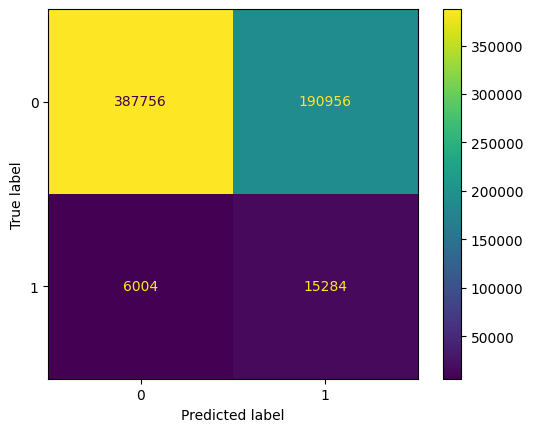

In [30]:
eval_classifier(res, x_test, y_test)

In [31]:
with open('model.pkl', 'wb') as f:
    dill.Pickler(f, recurse=True).dump(res)




In [32]:
#проверим, что все работает после сериализации
with open('/kaggle/working/model.pkl', 'rb') as f:
    restest = dill.load(f) 


In [47]:
#проверим, что работает трансформер
samp = x_test.sample(n=3)
samp.reset_index(drop=True, inplace=True)
restest['transformer'].transform(samp)

,enc_paym_value0,enc_paym_value2,no_delays,pre_loans_max_overdue_sum_1,pre_loans530_13,enc_paym_9_0,enc_paym_9_3,pre_fterm_0,pre_fterm_1,pre_fterm_3,...,enc_loans_credit_type_0_avg,no_delays_avg,pre_loans_credit_cost_rate_6_avg,enc_paym_value1_avg,pre_util_6_avg,pre_util_3_avg,mod1_1,mod2_1,mos=3_1,if
0,-0.103310,-0.319735,0.673567,-0.427788,-0.311778,-0.090162,0.772141,0.516986,-0.538554,-0.239964,...,0.517862,0.596240,-0.156009,-0.487358,0.803812,0.367095,0.241818,0.389350,0.044856,1
1,0.818197,-0.319735,0.867728,-0.427788,-0.311778,1.056242,-0.298439,-0.589566,-0.538554,-0.239964,...,-0.342864,0.942752,-0.156009,-0.562584,-0.271329,-0.391822,0.111388,0.190909,0.054000,1
2,0.235479,3.160445,-0.685560,4.823898,1.908866,-0.090162,-0.030794,0.516986,0.799470,-0.239964,...,-0.342864,-1.867840,-0.156009,3.315769,-0.271329,-0.391822,0.596555,0.545237,0.141719,1


In [48]:
#проверим, что работает классификатор
restest.predict(samp)

array([0, 0, 1])

ROC AUC=0.761
              precision    recall  f1-score   support

           0       0.98      0.67      0.80    578712
           1       0.07      0.72      0.13     21288

    accuracy                           0.67    600000
   macro avg       0.53      0.69      0.47    600000
weighted avg       0.95      0.67      0.77    600000



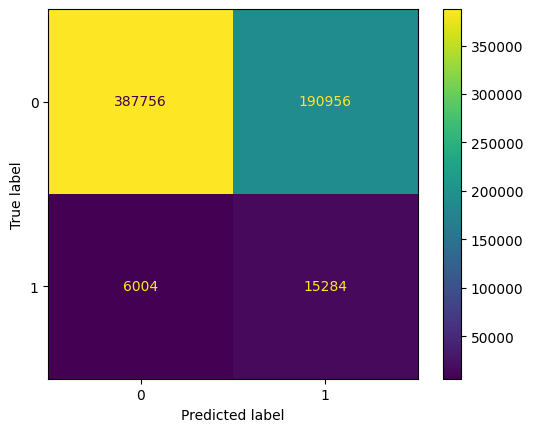

In [42]:
eval_classifier(restest, x_test, y_test)